In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import unyt as u

import richio
import nb, dev

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
!ls /data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_45

CMx_45.npy  Diss_45.npy  DpDz_45.npy	 P_45.npy     Vol_45.npy  box_45.npy
CMy_45.npy  DivV_45.npy  Entropy_45.npy  Rad_45.npy   Vx_45.npy   tfb_45.txt
CMz_45.npy  DpDx_45.npy  IE_45.npy	 Star_45.npy  Vy_45.npy
Den_45.npy  DpDy_45.npy  Mass_45.npy	 T_45.npy     Vz_45.npy


## Read HDF5 files

In [ ]:
hdf5_path = '/data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_45/snap_45.h5'
snap = richio.load(hdf5_path)
type(snap)

richio.data.SnapshotNPY

In [7]:
print(snap.keys())

['CMx', 'CMy', 'CMz', 'Den', 'Diss', 'DivV', 'DpDx', 'DpDy', 'DpDz', 'Entropy', 'IE', 'Mass', 'P', 'Rad', 'Star', 'T', 'Vol', 'Vx', 'Vy', 'Vz', 'box', 'tfb']


## Read npy directory

In [9]:
dir_path = '/data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_45'
snap = richio.load(dir_path)
type(snap)

richio.data.SnapshotNPY

In [10]:
print(snap.keys())

['CMx', 'CMy', 'CMz', 'Den', 'Diss', 'DivV', 'DpDx', 'DpDy', 'DpDz', 'Entropy', 'IE', 'Mass', 'P', 'Rad', 'Star', 'T', 'Vol', 'Vx', 'Vy', 'Vz', 'box', 'tfb']


## Accessing data

Richio only stores two metadata to minimise ram usage. Other information are read from the dataset.

In [11]:
# Basic info
print(snap.snapnum)
print(snap.path)

45
/data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_45


### Unit

In [12]:
density = snap.density
print(density)

[1.00000183e-20 1.00000105e-20 9.99999079e-21 ... 7.44195597e-06
 2.50614240e-05 9.29200811e-06] code_mass/code_length**3


In [13]:
density = density.in_cgs()
print(density)

[5.83091444e-20 5.83090992e-20 5.83089842e-20 ... 4.33933292e-05
 1.46130752e-04 5.41808053e-05] g/cm**3


In [14]:
density = density.in_base('rich')
print(density)

[1.00000183e-20 1.00000105e-20 9.99999079e-21 ... 7.44195597e-06
 2.50614240e-05 9.29200811e-06] code_mass/code_length**3


In [15]:
# Meta data
print(snap.time)
print(snap.box)

0.8335843382438486 day
[-1773.82236977 -1920.16264535 -1377.97182766  1337.1307531
  1540.01036475  1587.10283768] code_length


In [19]:
# Dimension checking
from unyt.dimensions import _has_dimensions, length, energy, time, volume
print(_has_dimensions(snap.box, length))
print(_has_dimensions(snap.dissipation, energy / time / volume))

True
True


### Aliases
Richio supports many aliases, so you would have a easy time switching from other softwares such as [swiftsimio](https://swiftsimio.readthedocs.io/en/latest/) or [yt](https://yt-project.org).

In [20]:
snap.info(unit_system='cgs', show_aliases=True)

                                     RICH SNAPSHOT INFORMATION                                      

Snapshot Details                        
----------------------------------------------------------------------------------------------------
  Path                      : /data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_45
  Snapshot Number           : 45
  Time                      : 72021.68682426852 s
  Box size                  : [-1.24167566e+14 -1.34411385e+14 -9.64580279e+13  9.35991527e+13
  1.07800726e+14  1.11097199e+14] cm
  Number of Cells           : 28,987,836

Available Fields                         [Unit System: CGS]
----------------------------------------------------------------------------------------------------
Field           Unit                                     Aliases
----------------------------------------------------------------------------------------------------
CMx             70000000000.0 cm                   

Access rich unit system by

In [22]:
richio.units.system

rich Unit System
 Base Units:
  length: code_length
  mass: code_mass
  time: code_time
  temperature: K
  angle: rad
  current_mks: A
  luminous_intensity: cd
  logarithmic: Np
 Other Units:

or equivalently from `unyt`, the rich unit system is registered when you import `richio`

In [23]:
import unyt as u
u.unit_systems.unit_system_registry['rich']

rich Unit System
 Base Units:
  length: code_length
  mass: code_mass
  time: code_time
  temperature: K
  angle: rad
  current_mks: A
  luminous_intensity: cd
  logarithmic: Np
 Other Units:

### Fancy indexing
Richio support full numpy [slicing and striding](https://numpy.org/doc/stable/user/basics.indexing.html).

In [24]:
density_subsample = snap.density[::1234]
print(density_subsample.shape)

density_subsample = snap['density', 1000:30000:100]
print(density_subsample.shape)

(23491,)
(290,)


## RICH specific masking

Richio provides necessary maskings in data processing, two complimentary masks to remove floor and spurious gases. Usually star_mask alone can filter out all the gases.

In [25]:
star_mask = snap.mask_star_ratio()
print(np.sum(star_mask), len(star_mask))

density_mask = snap.mask_density()
print(np.sum(density_mask), len(density_mask))

mask = star_mask & density_mask
print(np.sum(mask), len(mask))

15750893 28987836
27692500 28987836
15750893 28987836


In [26]:
density = snap.density
density_masked = density[mask]
print(len(density_masked))
print(density_masked)

15750893
[5.87309024e-17 9.42250596e-17 9.94775429e-16 ... 7.44195597e-06
 2.50614240e-05 9.29200811e-06] code_mass/code_length**3


## Plotting
RICHIO currently offers two types of plots, slice and projection plots.

In [27]:
import matplotlib.pyplot as plt

### Quick peek: A slice through xy midplane

(<Axes: >,
 unyt_array([[5.83091550e-20, 5.83091550e-20, 5.83091550e-20, ...,
         5.83090891e-20, 5.83090891e-20, 5.83090891e-20],
        [5.83091550e-20, 5.83091550e-20, 5.83091550e-20, ...,
         5.83090891e-20, 5.83090891e-20, 5.83090891e-20],
        [5.83091550e-20, 5.83091550e-20, 5.83091550e-20, ...,
         5.83090891e-20, 5.83090891e-20, 5.83090891e-20],
        ...,
        [5.83091747e-20, 5.83091747e-20, 5.83091747e-20, ...,
         5.83090943e-20, 5.83090943e-20, 5.83090943e-20],
        [5.83091747e-20, 5.83091747e-20, 5.83091747e-20, ...,
         5.83090943e-20, 5.83090943e-20, 5.83090943e-20],
        [5.83091747e-20, 5.83091747e-20, 5.83091747e-20, ...,
         5.83090943e-20, 5.83090943e-20, 5.83090943e-20]], shape=(512, 512), units='g/cm**3'))

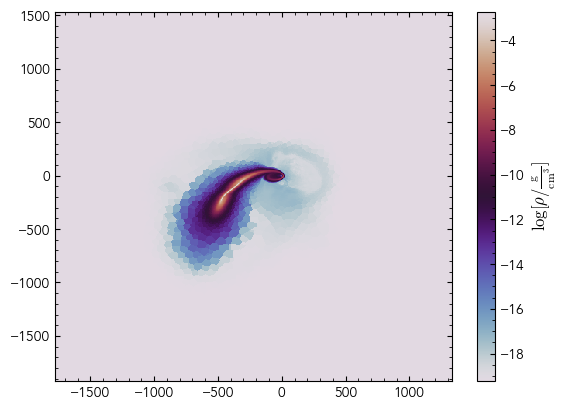

In [ ]:
# returns the axes, quadmesh object returned from pcolormesh, and the 2D
# unyt_array data that is plotted. With the quadmesh object you can change
# colorbar and stuff without replotting, very handy.
ax, im, data = snap.plots.peek()

### Slicing plot

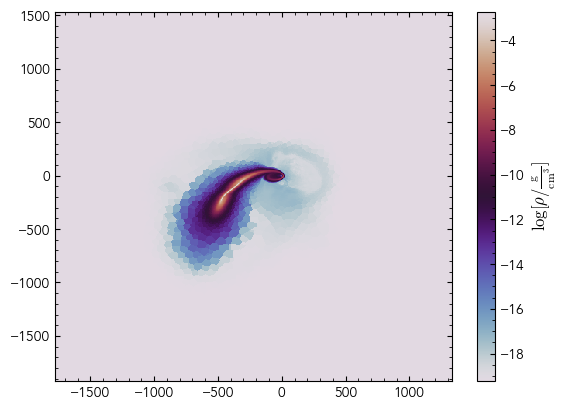

In [ ]:
ax, im, sliced_data = snap.plots.slice(data='density',
                                   x='CMx',
                                   y='CMy',
                                   z='CMz',
                                   res=512,
                                   plane='xy',
                                   slice_coord=0*richio.units.lscale,
                                   )
plt.show()

### Projection plot

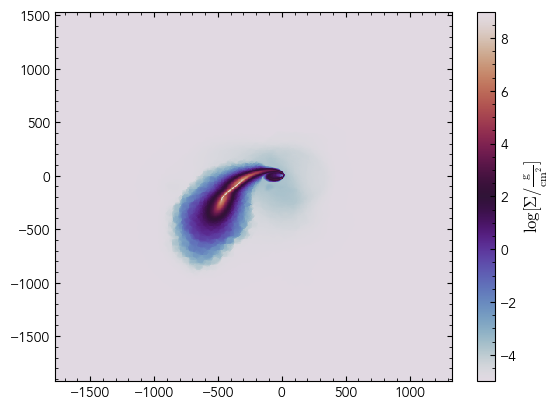

In [ ]:
ax, im, projected_data = snap.plots.projection(data='density', 
                                           x='CMx', 
                                           y='CMy', 
                                           z='CMz', 
                                           res=512
                                           )
plt.show()